In [1]:
pip install imutils

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 23.1.2 -> 23.2.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [2]:
pip install opencv-python

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 23.1.2 -> 23.2.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [3]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import AveragePooling2D
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Input
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from imutils import paths
import matplotlib.pyplot as plt
import numpy as np
import os
import pickle

In [4]:
INIT_LR = 1e-4
EPOCHS = 20
BS = 32

In [5]:
DIRECTORY = r"C:\Users\Nivedita\OneDrive\Desktop\ML-Mask Recognition\dataset"
CATEGORIES = ["with_mask", "without_mask"]

In [6]:
# print("[INFO] loading images...")

In [7]:
data = []
labels = []

for category in CATEGORIES:
    path = os.path.join(DIRECTORY, category)
    for img in os.listdir(path):
        img_path = os.path.join(path, img)
        image = load_img(img_path, target_size=(224, 224))
        image = img_to_array(image)
        image = preprocess_input(image)

        data.append(image)
        labels.append(category)

C:\python 3.11\Lib\site-packages\PIL\Image.py:992: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


In [8]:
lb = LabelBinarizer()
labels = lb.fit_transform(labels)
labels = to_categorical(labels)

data = np.array(data, dtype="float32")
labels = np.array(labels)

(trainX, testX, trainY, testY) = train_test_split(data, labels,
    test_size=0.20, stratify=labels, random_state=42)

In [9]:
aug = ImageDataGenerator(
    rotation_range=20,
    zoom_range=0.15,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.15,
    horizontal_flip=True,
    fill_mode="nearest")

In [10]:
baseModel = MobileNetV2(weights="imagenet", include_top=False,
    input_tensor=Input(shape=(224, 224, 3)))

In [11]:
headModel = baseModel.output
headModel = AveragePooling2D(pool_size=(7, 7))(headModel)
headModel = Flatten(name="flatten")(headModel)
headModel = Dense(128, activation="relu")(headModel)
headModel = Dropout(0.5)(headModel)
headModel = Dense(2, activation="softmax")(headModel)

In [12]:
model = Model(inputs=baseModel.input, outputs=headModel)

for layer in baseModel.layers:
    layer.trainable = False

In [13]:
from keras.optimizers import Adam as LegacyAdam

In [14]:
print("[INFO] compiling model...")
# opt = Adam(lr=INIT_LR, decay=INIT_LR / EPOCHS)

opt = LegacyAdam(lr=INIT_LR, decay=INIT_LR / EPOCHS)

model.compile(loss="binary_crossentropy", optimizer=opt,
    metrics=["accuracy"])

# train the head of the network
print("[INFO] training head...")
H = model.fit(
	aug.flow(trainX, trainY, batch_size=BS),
	steps_per_epoch=len(trainX) // BS,
	validation_data=(testX, testY),
	validation_steps=len(testX) // BS,
	epochs=EPOCHS)


[INFO] compiling model...
[INFO] training head...


C:\python 3.11\Lib\site-packages\keras\optimizers\legacy\adam.py:117: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


Epoch 1/20
95/95 [==============================] - 80s 806ms/step - loss: 0.4121 - accuracy: 0.8448 - val_loss: 0.1467 - val_accuracy: 0.9896
Epoch 2/20
95/95 [==============================] - 69s 730ms/step - loss: 0.1498 - accuracy: 0.9661 - val_loss: 0.0760 - val_accuracy: 0.9909
Epoch 3/20
95/95 [==============================] - 67s 703ms/step - loss: 0.0966 - accuracy: 0.9779 - val_loss: 0.0529 - val_accuracy: 0.9922
Epoch 4/20
95/95 [==============================] - 69s 722ms/step - loss: 0.0780 - accuracy: 0.9802 - val_loss: 0.0451 - val_accuracy: 0.9922
Epoch 5/20
95/95 [==============================] - 74s 775ms/step - loss: 0.0610 - accuracy: 0.9815 - val_loss: 0.0408 - val_accuracy: 0.9922
Epoch 6/20
95/95 [==============================] - 76s 800ms/step - loss: 0.0536 - accuracy: 0.9832 - val_loss: 0.0357 - val_accuracy: 0.9922
Epoch 7/20
95/95 [==============================] - 69s 722ms/step - loss: 0.0545 - accuracy: 0.9848 - val_loss: 0.0348 - val_accuracy: 0.9922

In [15]:
print("[INFO] evaluating network...")
predIdxs = model.predict(testX, batch_size=BS)


predIdxs = np.argmax(predIdxs, axis=1)


print(classification_report(testY.argmax(axis=1), predIdxs,
	target_names=lb.classes_))

# serialize the model to disk
print("[INFO] saving mask detector model...")
model.save("mask_detector.model", save_format="h5")

[INFO] evaluating network...
24/24 [==============================] - 15s 567ms/step
              precision    recall  f1-score   support

   with_mask       0.99      1.00      0.99       383
without_mask       1.00      0.99      0.99       384

    accuracy                           0.99       767
   macro avg       0.99      0.99      0.99       767
weighted avg       0.99      0.99      0.99       767

[INFO] saving mask detector model...


In [16]:
filename = 'mask_model.pkl'

In [17]:
pickle.dump(model,open(filename,'wb'))

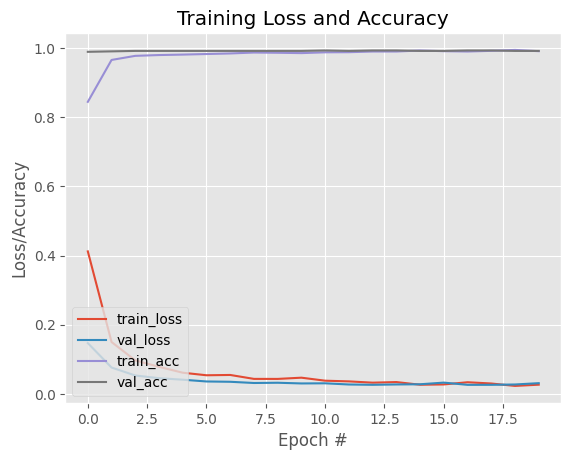

In [18]:
N = EPOCHS
plt.style.use("ggplot")
plt.figure()
plt.plot(np.arange(0, N), H.history["loss"], label="train_loss")
plt.plot(np.arange(0, N), H.history["val_loss"], label="val_loss")
plt.plot(np.arange(0, N), H.history["accuracy"], label="train_acc")
plt.plot(np.arange(0, N), H.history["val_accuracy"], label="val_acc")
plt.title("Training Loss and Accuracy")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend(loc="lower left")
plt.savefig("plot.png")